In [15]:
# input: manual-periodogram
# output: ebai-estimates

import phoebe
from phoebe import u, c

import numpy as np

import os
import sys
from pathlib import Path
baseModulePath = str(Path(os.getcwd()).parents[2].absolute())
if baseModulePath not in sys.path:
	sys.path.append(baseModulePath)

import importlib
import analisis.phoebe_model.utils as gen_utils
importlib.reload(gen_utils)

logger = phoebe.logger(clevel='WARNING')

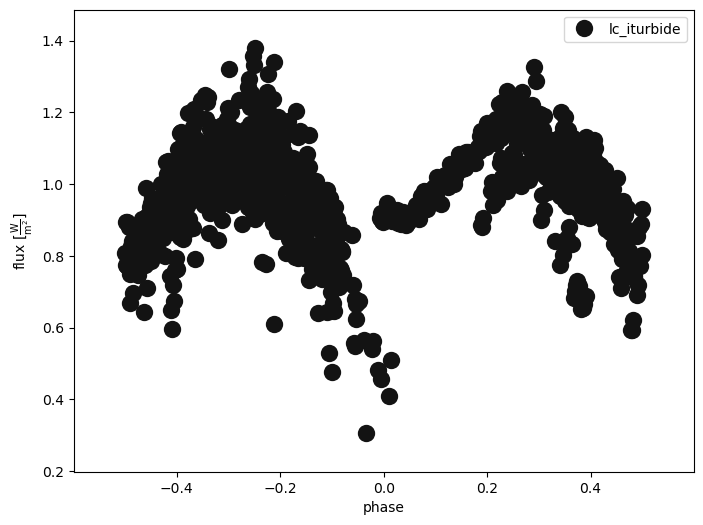

(<autofig.figure.Figure | 1 axes | 1 call(s)>,
 <Figure size 800x600 with 1 Axes>)

In [16]:
b = phoebe.load("./bundle-saves/manual-periodogram")
b.plot(x='phase', dataset='lc_iturbide', show=True, legend=True)

In [17]:
b.set_value(qualifier='pblum_mode', dataset='lc_iturbide', value='dataset-scaled')
print(b['pblum_mode'])

ParameterSet: 8 parameters
   pblum_mode@lc_iturbide@dataset: dataset-scaled
   pblum_mode@lc_iturbide_raw@...: component-coupled
     pblum_mode@lc_gaia_g@dataset: component-coupled
    pblum_mode@lc_gaia_rp@dataset: component-coupled
    pblum_mode@lc_gaia_bp@dataset: component-coupled
   pblum_mode@lc_gaia_g_raw@da...: component-coupled
   pblum_mode@lc_gaia_rp_raw@d...: component-coupled
   pblum_mode@lc_gaia_bp_raw@d...: component-coupled


100%|██████████| 1087/1087 [00:33<00:00, 32.18it/s]
Thu, 27 Jul 2023 16:18 BUNDLE       WARNING dataset-scaling: adopting sigmas=0.000982399093011984 for dataset='lc_iturbide'


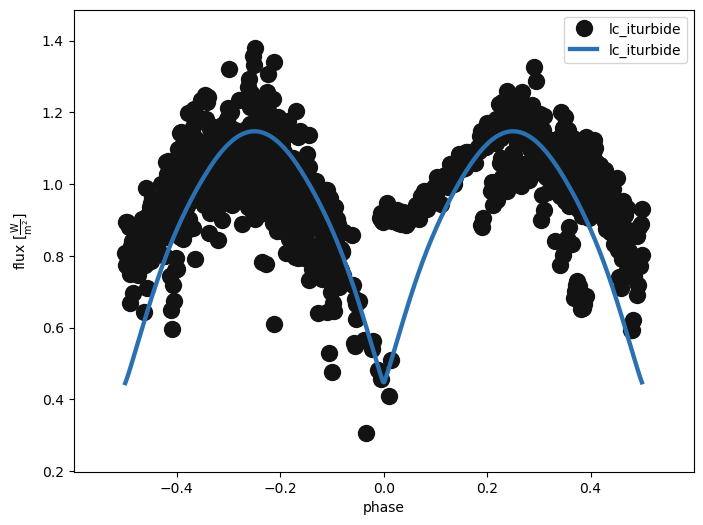

In [18]:
# run and show default forward model
gen_utils.avoidAtmosphereErrors(b)
b.run_compute(compute='fast_compute')
b.plot(x='phase', dataset='lc_iturbide', show=True, legend=True)
gen_utils.resetAtmosphere(b)

In [19]:
b.add_solver('estimator.ebai', ebai_method='knn', phase_bin=False, solver='ebai_knn', lc_datasets=['lc_iturbide'], overwrite=True)
print(b['ebai_knn'])

ParameterSet: 6 parameters
         comments@ebai_knn@solver: 
       use_server@ebai_knn@solver: none
      lc_datasets@ebai_knn@solver: ['lc_iturbide']
        phase_bin@ebai_knn@solver: False
      ebai_method@ebai_knn@solver: knn
            orbit@ebai_knn@solver: binary


In [20]:
b.run_solver(solver='ebai_knn', solution='ebai_knn_solution', overwrite=True)
gen_utils.printFittedVals(b, 'ebai_knn_solution')
print()
gen_utils.printFittedTwigsConstraints(b, 'ebai_knn_solution')

/home/ramon/anaconda3/envs/mapta-tesis-310/lib/python3.10/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator KNeighborsRegressor from version 1.0.2 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/ramon/anaconda3/envs/mapta-tesis-310/lib/python3.10/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator MinMaxScaler from version 1.0.2 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


t0_supconj@binary@orbit@component = -0.01 d
teffratio@binary@orbit@component = 0.87 
incl@binary@orbit@component = 1.26 rad
fillout_factor@contact_envelope@envelope@component = 0.30 
q@binary@orbit@component = 6.56 

ParameterSet: 1 parameters
      t0_supconj@binary@component: 0.0 d
ParameterSet: 1 parameters
C      teffratio@binary@component: 1.0
ParameterSet: 1 parameters
            incl@binary@component: 90.0 deg
ParameterSet: 1 parameters
C  fillout_factor@contact_enve...: 0.6417897080770951
ParameterSet: 1 parameters
               q@binary@component: 1.0


In [21]:
print(b['teffratio'])
print(b['fillout_factor'])
print(b['teff'])

ParameterSet: 2 parameters
C      teffratio@binary@component: 1.0
             teffratio@constraint: {teff@secondary@component} / {teff@primary@component}
ParameterSet: 2 parameters
C  fillout_factor@contact_enve...: 0.6417897080770951
        fillout_factor@constraint: pot_to_fillout_factor({q@binary@component}, {pot@contact_envelope@component})
ParameterSet: 2 parameters
           teff@primary@component: 6000.0 K
         teff@secondary@component: 6000.0 K


In [22]:
print(b['ebai_knn_solution'])

ParameterSet: 13 parameters
R  orbit@ebai_knn_solution@sol...: binary
R  input_phases@ebai_knn_solut...: [-0.46583372 -0.46509418
 -0.4637451  ... -0.4692905
 -0.46792211 -0.4671827 ]
R  input_fluxes@ebai_knn_solut...: [0.80884273 0.89414753 0.77433817
 ... 0.88996114 0.80212977
 0.93195383]
R  input_sigmas@ebai_knn_solut...: [0.0009824 0.0009824 0.0009824
 ... 0.0009824 0.0009824
 0.0009824]
R  ebai_phases@ebai_knn_soluti...: [-0.5   -0.495 -0.49  ...  0.49
  0.495  0.5  ]
R  ebai_fluxes@ebai_knn_soluti...: [0.83287712 0.82588541 0.8198265
 ... 0.84927566 0.84070791
 0.83287712]
R  fitted_twigs@ebai_knn@ebai_...: ['t0_supconj@binary@orbit@component' 'teffratio@binary@orbit@component'
 'incl@binary@orbit@component'
 'fillout_factor@contact_envelope@envelope@component'
 'q@binary@orbit@component']
R  fitted_values@ebai_knn@ebai...: [-0.011265065282531031 0.8749712934485144 1.26241927875795
 0.29767703119636457 6.555639267502973]
R  fitted_units@ebai_knn@ebai_...: ['d' '' 'rad' '' '']
  

In [23]:
b.flip_constraint('teffratio', solve_for='teff@secondary')
b.flip_constraint('pot@contact_envelope', solve_for='requiv@primary')
b.flip_constraint('fillout_factor', solve_for='pot@contact_envelope')

<ConstraintParameter: {pot@contact_envelope@component} = fillout_factor_to_pot({q@binary@component}, {fillout_factor@contact_envelope@component}) (solar units) => 3.4013774072298766>

In [24]:
backupBundle = b.copy()
backupBundle

<PHOEBE Bundle: 669 parameters | contexts: setting, constraint, system, model, component, dataset, figure, solver, compute, solution>

In [27]:
b = backupBundle.copy()

100%|██████████| 1087/1087 [00:34<00:00, 31.60it/s]
Thu, 27 Jul 2023 16:28 BUNDLE       WARNING dataset-scaling: adopting sigmas=0.000982399093011984 for dataset='lc_iturbide'


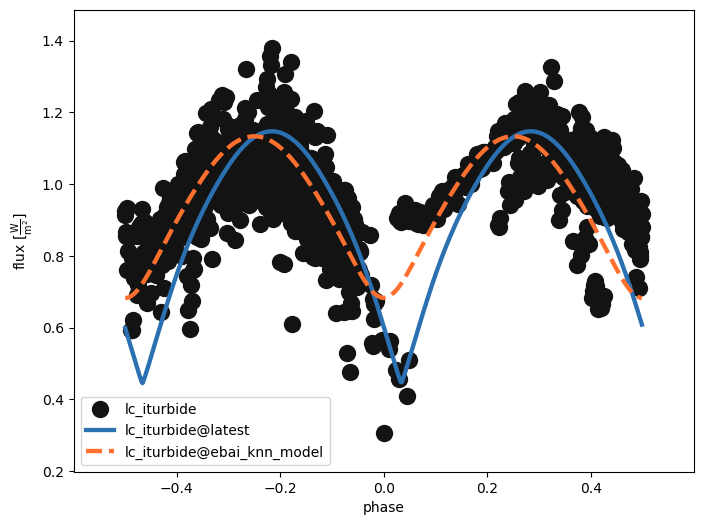

<Figure size 800x600 with 0 Axes>

In [28]:
# ['t0_supconj@binary@orbit@component', 'teffratio@binary@orbit@component', 'incl@binary@orbit@component', 
# 	'fillout_factor@contact_envelope@envelope@component', 'q@binary@orbit@component']


b.adopt_solution(solution='ebai_knn_solution',
                 adopt_parameters=['t0_supconj@binary@orbit@component',
                                   'incl@binary@orbit@component'])

# b.adopt_solution(solution='ebai_knn_solution',
#                  adopt_parameters=['t0_supconj@binary@orbit@component', 'teffratio@binary@orbit@component', 'incl@binary@orbit@component', 
# 	                                'fillout_factor@contact_envelope@envelope@component', 'q@binary@orbit@component'])

b.set_value_all(qualifier='enabled', dataset='mesh01', value=True)

gen_utils.avoidAtmosphereErrors(b)
b.run_compute(model='ebai_knn_model', compute='fast_compute', overwrite=True)
gen_utils.resetAtmosphere(b)

b.plot(x='phase', dataset='lc_iturbide', show=True, legend=True)
gen_utils.animateMesh(b, logger)

In [47]:
b.save("./bundle-saves/ebai-estimates")

'./bundle-saves/ebai-estimates'